In [6]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
learning_rate = 1e-4
keep_prob_rate = 0.5
max_epoch = 1
BATCH_SIZE = 50

DOWNLOAD_MNIST = False
if not(os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
    # not mnist dir or mnist is empyt dir
    DOWNLOAD_MNIST = True


train_data = torchvision.datasets.MNIST(root='./mnist/', train=True, transform = torchvision.transforms.ToTensor(), download=DOWNLOAD_MNIST,)
train_loader = Data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)

test_data = torchvision.datasets.MNIST(root = './mnist/',train = False)
test_x = Variable(torch.unsqueeze(test_data.test_data, dim = 1),volatile = True).type(torch.FloatTensor)[:500]/255.
test_y = test_data.test_labels[:500].numpy()

/tmp/ipykernel_7869/887533527.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  test_x = Variable(torch.unsqueeze(test_data.test_data, dim = 1),volatile = True).type(torch.FloatTensor)[:500]/255.


========== 20 ========== test accuracy is 0.358 ==========
========== 40 ========== test accuracy is 0.484 ==========
========== 60 ========== test accuracy is 0.706 ==========
========== 80 ========== test accuracy is 0.806 ==========
========== 100 ========== test accuracy is 0.85 ==========
========== 120 ========== test accuracy is 0.884 ==========
========== 140 ========== test accuracy is 0.896 ==========
========== 160 ========== test accuracy is 0.932 ==========
========== 180 ========== test accuracy is 0.95 ==========
========== 200 ========== test accuracy is 0.944 ==========
========== 220 ========== test accuracy is 0.934 ==========
========== 240 ========== test accuracy is 0.948 ==========
========== 260 ========== test accuracy is 0.964 ==========
========== 280 ========== test accuracy is 0.944 ==========
========== 300 ========== test accuracy is 0.952 ==========
========== 320 ========== test accuracy is 0.966 ==========
========== 340 ========== test accuracy is 0.9

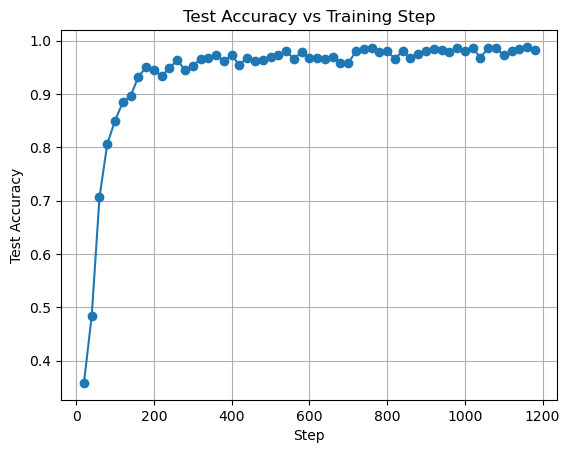

In [ ]:
class myAlexNet(nn.Module):
    def __init__(self):
        super(myAlexNet, self).__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=96,
                kernel_size=5,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=96,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=384,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
        )

        self.conv_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=384,
                out_channels=384,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
        )

        self.conv_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=384,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(256 * 3 * 3, 4096),
            nn.ReLU(),
            nn.Dropout(keep_prob_rate),
        )

        self.fc_2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(keep_prob_rate),
        )

        self.fc_3 = nn.Sequential(
            nn.Linear(4096, 10),
        )
    def saveXasjpg(self, x, layer):
        x = x.data.numpy()
        x = np.squeeze(x)
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
        x = (x * 255).astype(np.uint8)
        for i in range(x.shape[0]):
            img = Image.fromarray(x[i])
            img.save(f'./img_output/output_{i}_{layer}.jpg')

    def forward(self, x):
        x = self.conv_1(x) # 1*28*28 -> 96*26*26
        x = F.max_pool2d(x, kernel_size=2, stride=2) # 96*26*26 -> 96*13*13
        x = self.conv_2(x) # 96*13*13 -> 256*13*13
        x = F.max_pool2d(x, kernel_size=2, stride=2) # 256*13*13 -> 256*6*6
        x = self.conv_3(x) # 256*6*6 -> 384*6*6
        x = self.conv_4(x) # 384*6*6 -> 384*6*6
        x = self.conv_5(x) # 384*6*6 -> 256*6*6
        x = F.max_pool2d(x, kernel_size=2, stride=2) # 256*6*6 -> 256*3*3
        x = x.view(x.size(0), -1)
        x = self.fc_1(x)
        x = self.fc_2(x)
        x = self.fc_3(x)
        return x
        
def test(alexnet):
    global prediction
    y_pre = alexnet(test_x)
    _,pre_index= torch.max(y_pre,1)
    pre_index= pre_index.view(-1)
    prediction = pre_index.data.numpy()
    correct  = np.sum(prediction == test_y)
    return correct / 500.0

def showXAfterConv(self, x):
    x = self.conv_1(x) # 1*28*28 -> 96*26*26
    

def train(alexnet):
    optimizer = torch.optim.Adam(alexnet.parameters(), lr=learning_rate)
    loss_func = nn.CrossEntropyLoss()

    step_list = []
    acc_list = []

    for epoch in range(max_epoch):
        for step, (x_, y_) in enumerate(train_loader):
            x, y = Variable(x_), Variable(y_)
            output = alexnet(x)
            loss = loss_func(output, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step != 0 and step % 20 == 0:
                test_acc = test(alexnet)
                print("=" * 10, step, "=" * 10, "test accuracy is", test_acc, "=" * 10)
                step_list.append(step)
                acc_list.append(test_acc)

    plt.figure()
    plt.plot(step_list, acc_list, marker='o')
    plt.title('Test Accuracy vs Training Step')
    plt.xlabel('Step')
    plt.ylabel('Test Accuracy')
    plt.grid(True)
    plt.savefig('test_accuracy_curve.png')  # 也可改为 plt.show() 直接显示
    plt.show()
                
if __name__ == '__main__':
    alexnet = myAlexNet()
    train(alexnet)

In [9]:
plt.savefig('acc_curve.png')

<Figure size 640x480 with 0 Axes>